In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pmdarima as pm
from math import sqrt


In [4]:
df=pd.read_csv('C:/Abdelouaheb/perso/Ph/time_series_analysis/data/data_article/hourly_5y_data.csv')

In [5]:
df['time'] = pd.to_datetime(df['time'])

In [6]:
# set datetime to index
df.set_index('time',inplace=True)

In [7]:
# check for null values
df.isnull().sum()

measure    0
dtype: int64

<AxesSubplot:xlabel='time'>

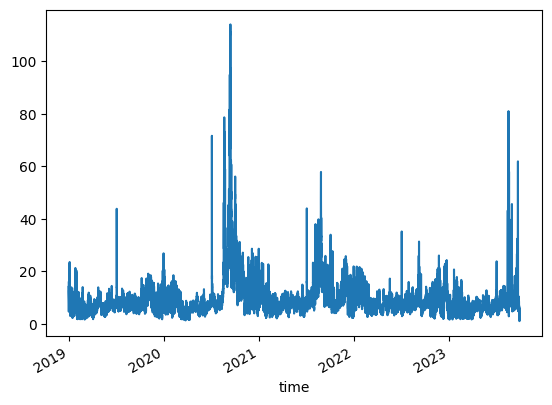

In [8]:
df['measure'].plot()

In [9]:
# resample the data as daily average
df1 = df.measure.resample('D').mean()

In [10]:
df1.head()

time
2019-01-01     9.328343
2019-01-02    11.654160
2019-01-03    14.615219
2019-01-04    16.761391
2019-01-05    10.259403
Freq: D, Name: measure, dtype: float64

In [11]:
# Understanding the data for time based train-test split
print(f'Start Date: {df1.index.min()}')
print(f'End Date: {df1.index.max()}')
print(f'Total Days: {len(df1)}')

Start Date: 2019-01-01 00:00:00
End Date: 2023-09-30 00:00:00
Total Days: 1734


<AxesSubplot:xlabel='time'>

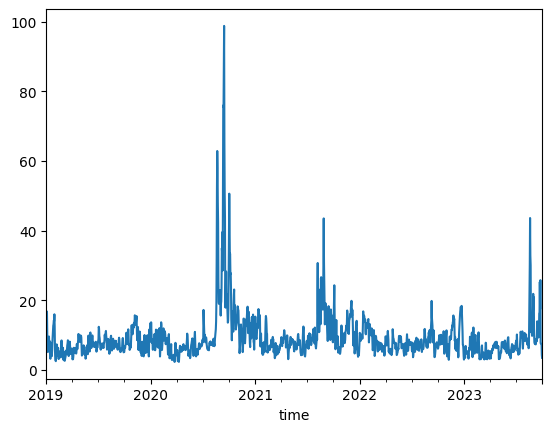

In [12]:
df1.plot()

<AxesSubplot:>

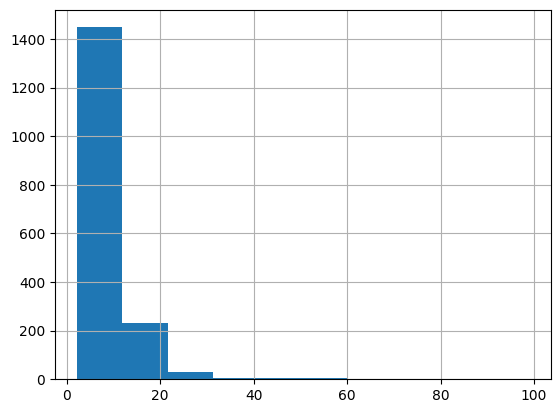

In [13]:
df1.hist()


In [14]:
# Defining a function that creates sequences and targets 
def generate_sequences(ts: pd.Series, tw: int, pw: int):
    '''
    df: Pandas Series of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(ts)
    for i in range(L-tw):
        # Get current sequence  
        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence),-1))
        # Get values right after the current sequence
        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target),-1))
        data[i] = {'sequence': sequence, 'target': target}
    return data

In [17]:
# import libraries
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


In [18]:
class SequenceDataset(Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)

In [19]:
# we are using 7 sequences to predict the next 1 value
lookback = 7 #training window
n_pred = 1 #prediction window

In [20]:
sequences = generate_sequences(df1, lookback, n_pred)

In [23]:
dataset = SequenceDataset(sequences)

In [21]:
split = 0.67 # Train/Test Split ratio

In [24]:
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]

In [25]:
lens

[1157, 570]

In [26]:
# random split of dataset into train and test set
r_train_ds, r_test_ds = random_split(dataset, lens)

In [27]:
# sequential split of dataset into train and test set 
s_train_ds = Subset(dataset, range(lens[0]))
s_test_ds = Subset(dataset, range(lens[0],lens[0]+lens[1]))

In [28]:
BATCH_SIZE = 8 # Training batch size

In [29]:
# create dataloaders
r_trainloader = DataLoader(r_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(r_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [30]:
# create dataloaders
s_trainloader = DataLoader(s_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_testloader = DataLoader(s_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [31]:
# reshape the data to be used as an input for LSTM
df1_ts = df1.values.astype('float32')
df1_ts = np.reshape(df1_ts, (len(df1_ts),-1))

In [32]:
# define a simple LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size #output size
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 32) #fully connected 1
        self.fc = nn.Linear(32, output_size) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #cell state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        #output = output[:,-1,:] # when using the last element of the output
        #hn = hn.view(-1, self.hidden_size) # when using the hidden state for forecasting
        out = self.relu(output)
        #out = self.relu(hn) # when using the hidden state for forecasting
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out) 
        return out

In [33]:
input_size = 1 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

output_size = 1 #output size

In [34]:
r_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback) #our lstm class 

In [35]:
num_epochs = 100 
learning_rate = 0.01

In [36]:
import torch.optim as optim
# define an optimizer, loss function, and data loader
r_optimizer = optim.Adam(r_model.parameters())
loss_fn = nn.MSELoss()

In [37]:
from torchinfo import summary
summary(r_model, input_size=(1, 7, 1))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleLSTM                               [1, 7, 1]                 --
├─LSTM: 1-1                              [1, 7, 64]                17,152
├─ReLU: 1-2                              [1, 7, 64]                --
├─Linear: 1-3                            [1, 7, 32]                2,080
├─ReLU: 1-4                              [1, 7, 32]                --
├─Linear: 1-5                            [1, 7, 1]                 33
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
Total mult-adds (M): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.08
Estimated Total Size (MB): 0.08

In [38]:
t_losses = []

for epoch in range(num_epochs):    
    
    train_loss = 0.0
    
    r_model.train()
    
    for X_batch, y_batch in r_trainloader:
        r_optimizer.zero_grad()    
        
        y_pred = r_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()
                
        loss.backward()
        r_optimizer.step()
    epoch_loss = train_loss / len(r_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 10 != 0:
        continue
            
    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))

c:\Users\waheb11\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: train MSE 84.3769
Epoch 10: train MSE 31.2536
Epoch 20: train MSE 29.9444
Epoch 30: train MSE 29.1217
Epoch 40: train MSE 28.1161
Epoch 50: train MSE 27.3619
Epoch 60: train MSE 24.6727
Epoch 70: train MSE 25.6856
Epoch 80: train MSE 24.9621
Epoch 90: train MSE 24.7316


In [39]:
s_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback)
s_optimizer = optim.Adam(s_model.parameters())
loss_fn = nn.MSELoss()

In [40]:
t_losses = []

for epoch in range(num_epochs):    
    
    train_loss = 0.0
    
    s_model.train()
    
    for X_batch, y_batch in s_trainloader:
        s_optimizer.zero_grad()    
        y_pred = s_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()
                
        loss.backward()
        s_optimizer.step()
    epoch_loss = train_loss / len(s_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 10 != 0:
        continue
            
    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))

Epoch 0: train MSE 102.1178
Epoch 10: train MSE 33.7978
Epoch 20: train MSE 33.0373
Epoch 30: train MSE 32.3990
Epoch 40: train MSE 31.4194
Epoch 50: train MSE 30.2908
Epoch 60: train MSE 28.9440
Epoch 70: train MSE 28.2343
Epoch 80: train MSE 27.1726
Epoch 90: train MSE 26.3895


In [41]:
unshuffled_dataloader= DataLoader(dataset,shuffle=False)

In [42]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            p = p[:,-1,:]
            predictions.append(p)
            actuals.append(y)
            #actuals.append(y.squeeze())
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions, actuals.squeeze()

In [43]:
r_preds, actuals = make_predictions_from_dataloader(r_model, unshuffled_dataloader)

In [44]:
s_preds, actuals = make_predictions_from_dataloader(s_model, unshuffled_dataloader)

In [45]:
def one_step_forecast(model, history):
    '''
    model: PyTorch model object
    history: a sequence of values representing the latest values of the time 
    series, requirement -> len(history.shape) == 2
    
    outputs a single value which is the prediction of the next value in the
    sequence.
    '''
    model.eval()
    with torch.no_grad():
        pre = torch.Tensor(history).unsqueeze(0)
        pred = model(pre)
        pred = pred[:,-1,:]
    return pred.detach().numpy().reshape(-1)

In [46]:
forecast = one_step_forecast(r_model, df1_ts)
forecast

array([4.7923083], dtype=float32)

In [47]:
def n_step_forecast(data, model, lookback: int, n: int, forecast_from: int=None):
    '''
    n: integer defining how many steps to forecast
    forecast_from: integer defining which index to forecast from. None if
    you want to forecast from the end.
    plot: True if you want to output a plot of the forecast, False if not.
    '''
    history = data.copy()
      
    # Create initial sequence input based on where in the series to forecast 
    # from.
    if forecast_from:
        pre = list(history[forecast_from - lookback : forecast_from])
    else:
        pre = list(history)[-lookback:]

    # Call one_step_forecast n times and append prediction to history
    for i, step in enumerate(range(n)):
        pre_ = np.array(pre[-lookback:]).reshape(-1, 1)
        forecast = one_step_forecast(model, pre_)
        #forecast = forecast[:,-1,:]
        pre.append(forecast)
      
    # The rest of this is just to add the forecast to the correct time of 
    # the history series
    res = history.copy()
    ls = [np.nan for i in range(len(history))]

    # Note: I have not handled the edge case where the start index + n is 
    # before the end of the dataset and crosses past it.
    if forecast_from:
        ls[forecast_from : forecast_from + n] = list(np.array(pre[-n:]))
        res['forecast'] = ls
        res.columns = ['actual', 'forecast']
    else:
        fc = ls + list(np.array(pre[-n:]))
        ls = ls + [np.nan for i in range(len(pre[-n:]))]
        ls[:len(history)] = history
        res = pd.DataFrame([ls, fc], index=['actual', 'forecast']).T
        forecast = res.forecast[-n:]
        forecast.index = pd.date_range('2017-07-01', periods=n, freq='D')

    #return res
    return forecast

In [48]:
r_lstm_forecast = n_step_forecast(df1_ts, r_model, lookback=7, n=30)
r_lstm_forecast

2017-07-01    [4.9020786]
2017-07-02    [5.9042974]
2017-07-03     [6.312325]
2017-07-04    [6.3342156]
2017-07-05     [6.296497]
2017-07-06     [6.250034]
2017-07-07    [6.1863647]
2017-07-08    [6.3008513]
2017-07-09     [6.451156]
2017-07-10     [6.534243]
2017-07-11     [6.560587]
2017-07-12     [6.571306]
2017-07-13    [6.5855827]
2017-07-14    [6.6037445]
2017-07-15    [6.6171174]
2017-07-16    [6.6217217]
2017-07-17     [6.620869]
2017-07-18    [6.6192026]
2017-07-19    [6.6185465]
2017-07-20    [6.6184306]
2017-07-21    [6.6180344]
2017-07-22     [6.617227]
2017-07-23     [6.616378]
2017-07-24    [6.6157947]
2017-07-25     [6.615498]
2017-07-26     [6.615349]
2017-07-27     [6.615235]
2017-07-28    [6.6151357]
2017-07-29      [6.61507]
2017-07-30    [6.6150455]
Freq: D, Name: forecast, dtype: object

In [51]:
s_lstm_forecast = n_step_forecast(df1_ts, s_model, lookback=7, n=30)
s_lstm_forecast

2017-07-01    [5.9585905]
2017-07-02    [7.4671707]
2017-07-03     [7.137971]
2017-07-04    [6.9322433]
2017-07-05     [7.118943]
2017-07-06     [7.112952]
2017-07-07    [7.1098423]
2017-07-08    [7.4605904]
2017-07-09     [7.873886]
2017-07-10      [7.94252]
2017-07-11    [7.8403964]
2017-07-12    [7.7970862]
2017-07-13    [7.7842255]
2017-07-14    [7.7655663]
2017-07-15      [7.78656]
2017-07-16     [7.847575]
2017-07-17    [7.8893504]
2017-07-18    [7.8896074]
2017-07-19     [7.875677]
2017-07-20    [7.8653545]
2017-07-21    [7.8573427]
2017-07-22     [7.853616]
2017-07-23     [7.858015]
2017-07-24     [7.866145]
2017-07-25    [7.8708506]
2017-07-26    [7.8709583]
2017-07-27    [7.8692083]
2017-07-28    [7.8672247]
2017-07-29    [7.8655953]
2017-07-30      [7.86508]
Freq: D, Name: forecast, dtype: object

In [53]:
lstm_forecast = n_step_forecast(df1_ts, s_model, lookback=7, n=30)
lstm_forecast

2017-07-01    [5.9585905]
2017-07-02    [7.4671707]
2017-07-03     [7.137971]
2017-07-04    [6.9322433]
2017-07-05     [7.118943]
2017-07-06     [7.112952]
2017-07-07    [7.1098423]
2017-07-08    [7.4605904]
2017-07-09     [7.873886]
2017-07-10      [7.94252]
2017-07-11    [7.8403964]
2017-07-12    [7.7970862]
2017-07-13    [7.7842255]
2017-07-14    [7.7655663]
2017-07-15      [7.78656]
2017-07-16     [7.847575]
2017-07-17    [7.8893504]
2017-07-18    [7.8896074]
2017-07-19     [7.875677]
2017-07-20    [7.8653545]
2017-07-21    [7.8573427]
2017-07-22     [7.853616]
2017-07-23     [7.858015]
2017-07-24     [7.866145]
2017-07-25    [7.8708506]
2017-07-26    [7.8709583]
2017-07-27    [7.8692083]
2017-07-28    [7.8672247]
2017-07-29    [7.8655953]
2017-07-30      [7.86508]
Freq: D, Name: forecast, dtype: object

In [54]:
# helper function to prepare modeled results
def prepare_results(model, preds, data, lookback):
    
    sample_plot = np.ones_like(data) * np.nan
    sample_plot[lookback:] = preds
    sample_df = pd.DataFrame(sample_plot, index=df1.index)
    return sample_df

In [55]:
r_modeled = prepare_results(r_model, r_preds, df1_ts, lookback=7)
r_modeled

,0
time,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-05,NaN
...,...
2023-09-26,9.867982
2023-09-27,8.537032
2023-09-28,8.530679


In [56]:
s_modeled = prepare_results(s_model, s_preds, df1_ts, lookback=7)
s_modeled

,0
time,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-05,NaN
...,...
2023-09-26,10.772218
2023-09-27,11.179968
2023-09-28,10.981622


In [57]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [58]:
# helper function to plot all the results for comparison
def plot_results(original, modeled, forecast): 
    """ Given 
        original: a time series with datetime index
        modeled: model fitted values
        forecast: inferenced values
        
        Plot the original time series and the prediction of the test set
    """

    # calculate RMSE values between the original and modeled
    error = root_mean_squared_error(original[train_len+lookback+1:],modeled[train_len+lookback+1:])

    # plot
    plt.figure(figsize=(15, 7))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(original, c='b', label="actual")
    plt.plot(modeled, c='r', label="modeled")
    plt.plot(forecast, color='r', label="forecast")
    plt.axvspan(original.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.legend()
    plt.grid(True);

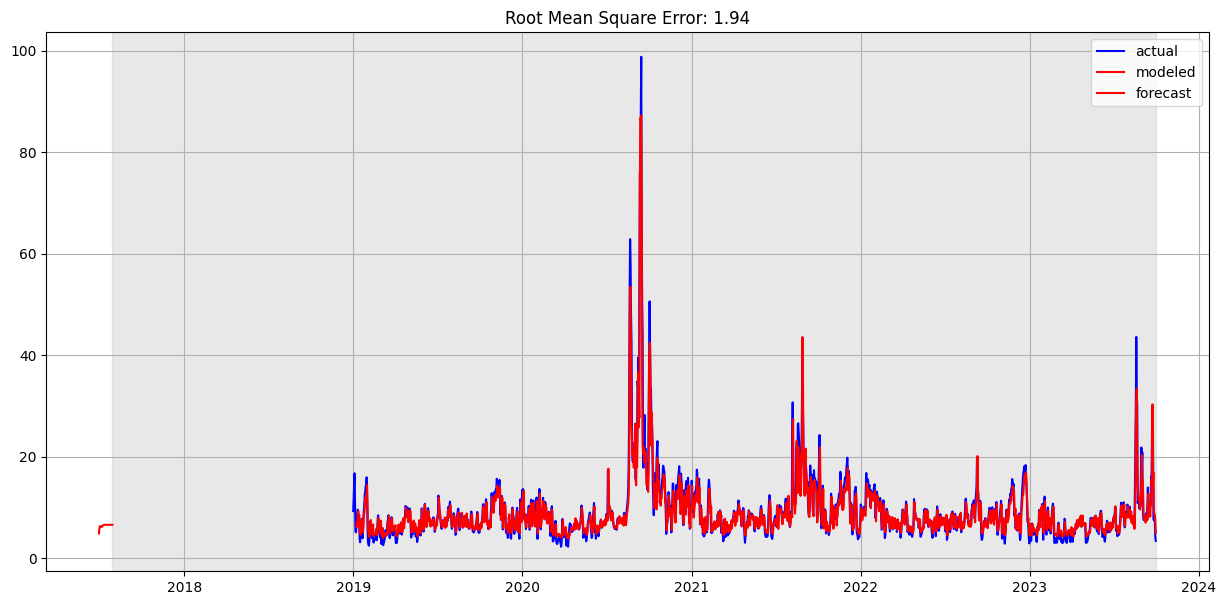

In [59]:
plot_results(df1, r_modeled, r_lstm_forecast)

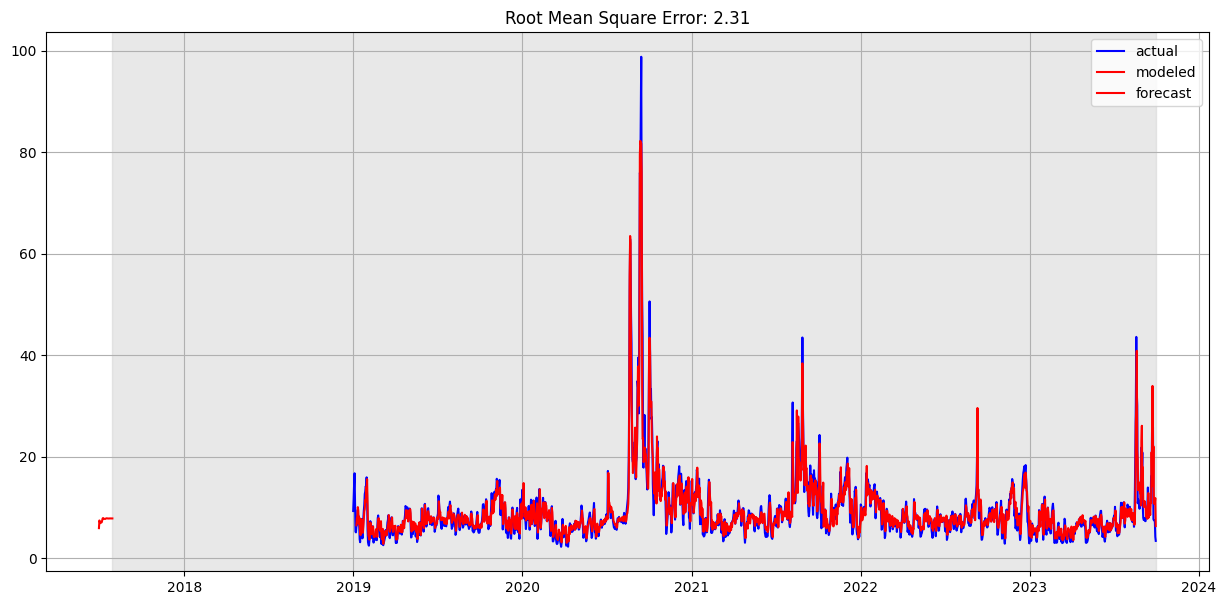

In [60]:
plot_results(df1, s_modeled, s_lstm_forecast)